In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from torchvision import models
from torch import nn
from torch import optim

In [3]:
nan_val = -32768.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_chips = '/home/oqbrady/data/data/chips/train/'
val_chips = '/home/oqbrady/data/data/chips/validation/'
train_files = os.listdir('/home/oqbrady/data/data/chips/train/')
val_scenes = os.listdir(val_chips)
train_scences = os.listdir(train_chips)

In [5]:
inference_scenes = pd.read_csv('inference_scenes.csv')
inference = inference_scenes['0'].to_list()

In [6]:
pos_image_path = '/home/oqbrady/data/data/sub_boxes/positives_v3/'
neg_image_path = '/home/oqbrady/data/data/sub_boxes/negatives/'

In [7]:
labels_train = pd.read_csv("labels_v4_train.csv")
# labels_val = pd.read_csv("labels_v3_val.csv")

In [8]:
names = ['bay_mean', 'vh_mean', 'vh_max', 'vv_max', 'vh_min', 'vv_min', 'land', 'NaN', 'label', 'scene', 'chip', 'num']
neg_samples = pd.read_csv("negative_chip_vals.csv", names=names)

In [9]:
neg_samples = neg_samples.drop(np.nan)

In [10]:
neg_samples.shape

(1937374, 12)

In [11]:
# bst = xgb.Booster()  # init model
# bst.load_model('gbt_v1.model')  # load data
# test = neg_samples.drop(labels=['label', 'scene', 'chip', 'num'], axis=1)
# dtest = xgb.DMatrix(test)
# ypred = bst.predict(dtest)
# predictions = ypred > 0.5
# neg_samples['preds'] = predictions
# pos_neg_samples = neg_samples[neg_samples['preds'] == 1]

In [12]:
pos_neg_samples = pd.read_csv("positive_negative_samples.csv")

In [13]:
df_gbt = pd.read_csv("train_GBT.csv", names=names[:-3])

In [14]:
df_means = df_gbt.copy()

In [15]:
df_gbt

,bay_mean,vh_mean,vh_max,vv_max,vh_min,vv_min,land,NaN,label
0,-99.964500,-30.477900,-26.203125,-13.328125,-37.12500,-30.203125,0.0,0.0,0.0
1,-3594.778809,-28.181025,-24.625000,-15.484375,-34.87500,-32.562500,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.0,0.0
3,-39.001675,-28.543694,-23.734375,-17.656250,-37.31250,-32.468750,0.0,0.0,0.0
4,-46.351612,-29.431162,-25.296875,-15.976562,-39.18750,-29.562500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1807139,-68.119278,-31.918276,-25.437500,-12.796875,-39.28125,-22.750000,0.0,0.0,0.0
1807140,-117.068878,-28.421625,-24.593750,-19.500000,-35.87500,-35.781250,0.0,0.0,0.0
1807141,-4764.534180,-32.727139,-27.000000,-21.421875,-38.81250,-35.125000,0.0,0.0,0.0
1807142,-125.340927,-30.516380,-25.765625,-13.593750,-37.43750,-27.921875,0.0,0.0,0.0


In [16]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [17]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [18]:
min_vh = df_means[df_means['vh_min'] != nan_val]['vh_min'].min()
min_vv = df_means[df_means['vv_min'] != nan_val]['vv_min'].min()
min_bay = df_means[(df_means['bay_mean'] != nan_val) & (df_means['NaN'] == 0)]['bay_mean'].min()

In [19]:
mean_vh = df_means[df_means['NaN'] != 1]['vh_mean'].mean()
mean_vv = -15 #df_means[df_means['NaN'] != 1]['vv_mean'].mean()
mean_bay = df_means[df_means['NaN'] != 1]['bay_mean'].mean()

In [20]:
std_vh = 7.4
std_vv = 5.15
std_bay = 1600

In [21]:
image_paths = []
labels = []

In [22]:
# base = neg_image_path
# for i in range(pos_neg_samples.shape[0]):
#     row = pos_neg_samples.iloc[i]
#     fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
#     image_paths.append(fl)
#     labels.append(0)

In [23]:
base = pos_image_path
for i in range(labels_train.shape[0]):
    row = labels_train.iloc[i]
    fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
    image_paths.append(fl)
    labels.append(row[['jitter_x', 'jitter_y']])

In [24]:
# base = '/home/oqbrady/data/data/sub_boxes/inference/'
# images = [base + x for x in os.listdir(base)]
# image_paths.extend(images)
# labels.extend([0] * len(images))

In [25]:
class SARImagery(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.images[idx]
        num = img_name.split("_")[-1]
        vh = np.load(img_name + '/' + num + '_vh.npy')
        vv = np.load(img_name + '/' + num + '_vv.npy')
        bay = np.load(img_name + '/' + num + '_bay.npy')
        image = np.array((vv, vh, bay))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        image = torch.from_numpy(image)
        if torch.isnan(image).any():
            image= torch.zeros((3, 50, 50))
        return (image.to(device), torch.tensor(label).to(device))

In [26]:
class drop_nans(object):
    def __call__(self, image):
        image[0, :, :][image[0, :, :] == -32768.] = min_vh - 10
        image[1, :, :][image[1, :, :] == -32768.] = min_vv - 10
        image[2, :, :][image[2, :, :] == -32768.] = min_bay - 100
        return image

class norm(object):
    def __call__(self, image):
        image[0, :, :] = (image[0, :, :] - mean_vh) / std_vh
        image[1, :, :] = (image[1, :, :] - mean_vv) / std_vv
        image[2, :, :] = (image[2, :, :] - mean_bay) / std_bay
        return image

In [27]:
transform = transforms.Compose(
    [drop_nans(),
    norm()])

In [28]:
dataset = SARImagery(image_paths, labels, transform=transform)

In [29]:
train_len = int(len(dataset) * 0.85)
val_len = len(dataset) - train_len

In [30]:
print(train_len, val_len)

39627 6993


In [31]:
train_data, val_data = torch.utils.data.random_split(dataset, lengths=[train_len,val_len])

In [32]:
labels_np = np.array(labels)

In [33]:
# class_counts = np.unique(labels_np, return_counts=True)[1]

In [34]:
# class_percent = class_counts / labels_np.shape[0]

In [35]:
# weights = 1 / class_percent

In [36]:
# class_percent

In [37]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=512, out_features=2, bias=True)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Dataset Prep

In [39]:
batch_size = 8
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=True)

In [40]:
print(len(train_data), len(val_data))

39627 6993


In [41]:
# w = torch.tensor(weights).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [42]:
best_model = ""
min_val = 1

In [43]:
train_l = []
val_l = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-5, 21], device='cuda:0')


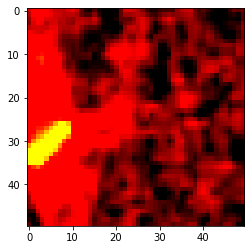

In [44]:
print(dataset[5][1])
plt.imshow(dataset[5][0].detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')

In [46]:
def jitter_score(preds, real):
    correct = 0
    total = 0
    for x, y in zip(preds, real):
        if ((x[0] - y[0])**2 + (x[1] - y[1])**2)**(1/2) < 20:
            correct += 1
        total += 1
    return correct / total

In [49]:
print("HEY")

HEY


In [50]:
base = 0
for epoch in range(5, 100):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    run_tot_loss = 0.0
    j = 0
    for i, data in tqdm(enumerate(trainloader, 0)):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        outputs = net(inputs)
        optimizer.zero_grad()
#         print(outputs)
#         print(labels)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        run_tot_loss += loss.item()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i + 1, running_loss / 1000))
            running_loss = 0.0
        j += 1
    train_l.append(run_tot_loss / j)
    running_val_loss = 0
    correct = 0
    total = 0
    torch.save(net.state_dict(), 'saved_models/resnet_jitter_' + str(epoch + base) + '.pth')
    k = 0
    net.eval()
    val_preds = []
    val_labels = []
    for j, data  in enumerate(valloader):
        k+=1
        images, labels = data
        with torch.no_grad():
            outputs = net(images)
            val_preds.append(outputs.detach().cpu().numpy())
            val_labels.append(labels.detach().cpu().numpy())
#             preds = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
#             correct += (preds == labels).sum()
#             total += labels.shape[0]
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    print("val_loss", running_val_loss / k)
    val_l.append(running_val_loss / k)
    val_acc = jitter_score(np.concatenate(val_preds), np.concatenate(val_labels))
    print(np.concatenate(val_preds)[:20])
    print(np.concatenate(val_labels)[:20])
    print("Val accuracy", val_acc)
    val_loss = running_val_loss / k
    if val_loss < min_val:
        min_val = val_loss2
        best_model = net
        best_epoch = epoch
print('Finished Training')

1000it [08:13,  2.15it/s]

[5,  1000] loss: 1.014


2000it [16:23,  2.15it/s]

[5,  2000] loss: 1.053


3000it [24:34,  2.04it/s]

[5,  3000] loss: 1.053


4000it [32:38,  2.39it/s]

[5,  4000] loss: 1.047


4954it [40:14,  2.05it/s]


val_loss 1.290619894163949
[[ -2.1331544   21.49863   ]
 [-16.939516   -14.3646755 ]
 [  9.318257   -10.298724  ]
 [ -8.528916    17.10138   ]
 [ 19.350798     0.9096161 ]
 [-15.540212   -22.833195  ]
 [ -9.203794   -13.295824  ]
 [  5.9612575  -19.201874  ]
 [  7.2098804   22.02678   ]
 [ 23.108591    18.066563  ]
 [ 16.90541      3.2874417 ]
 [-14.406173   -21.27064   ]
 [  4.638288   -23.360575  ]
 [ 15.914397    -7.676433  ]
 [-15.0445795   16.24173   ]
 [-11.587858    -9.960508  ]
 [ 19.85576     10.350042  ]
 [-10.721046    -7.478467  ]
 [-14.663698    -6.915161  ]
 [ 19.817118    -0.14908466]]
[[ -2  24]
 [-22 -15]
 [ 11 -10]
 [ -8  18]
 [ 20   0]
 [-16 -23]
 [-13 -13]
 [  7 -20]
 [ 10  24]
 [ 23  20]
 [ 16   2]
 [-15 -23]
 [  7 -24]
 [ 17  -9]
 [-17  13]
 [-12 -11]
 [ 24   8]
 [-10 -12]
 [-16  -8]
 [ 22  -1]]
Val accuracy 0.9971399971399971


1000it [07:03,  2.95it/s]

[6,  1000] loss: 1.014


2000it [13:41,  2.51it/s]

[6,  2000] loss: 0.997


3000it [20:06,  2.25it/s]

[6,  3000] loss: 0.997


4000it [26:42,  2.47it/s]

[6,  4000] loss: 1.000


4954it [32:57,  2.51it/s]


val_loss 1.338409605366843
[[ 20.935076    -4.2798405 ]
 [ -7.4807143  -11.671401  ]
 [-12.19886     -7.917901  ]
 [-12.8612     -11.21167   ]
 [ 17.162006     1.9231193 ]
 [ -0.59452677  -5.8057966 ]
 [ 11.012681    -1.6157026 ]
 [  2.0218666  -10.760457  ]
 [-23.039219   -22.048357  ]
 [-19.725832     5.16402   ]
 [-22.072838    22.384165  ]
 [ 19.419043    15.948017  ]
 [ 14.801757   -11.014196  ]
 [  0.2439298  -19.5501    ]
 [-17.95037      9.121357  ]
 [  3.992044   -19.997217  ]
 [ 13.893529   -17.83427   ]
 [ 23.113749     0.5629507 ]
 [-10.387123     8.080397  ]
 [ 20.580652     3.624008  ]]
[[ 21  -5]
 [ -8 -14]
 [-17  -8]
 [-14 -12]
 [ 20   1]
 [ -1  -7]
 [ 10  -2]
 [  2 -12]
 [-25 -23]
 [-22   5]
 [-24  24]
 [ 23  16]
 [ 18 -12]
 [ -1 -21]
 [-20  11]
 [  4 -21]
 [ 15 -19]
 [ 24   1]
 [-11   8]
 [ 24  -1]]
Val accuracy 0.9974259974259975


1000it [06:08,  2.83it/s]

[7,  1000] loss: 0.965


2000it [12:02,  2.78it/s]

[7,  2000] loss: 0.979


3000it [17:55,  2.84it/s]

[7,  3000] loss: 0.974


4000it [23:49,  2.79it/s]

[7,  4000] loss: 0.965


4954it [29:38,  2.79it/s]


val_loss 1.359261661529541
[[-17.474628   -21.09754   ]
 [-18.973776    17.201223  ]
 [-21.146816    -9.164984  ]
 [-22.685741    -4.6532645 ]
 [-19.38539    -17.246223  ]
 [ 16.296543   -18.107775  ]
 [ 15.454194     1.4931107 ]
 [-10.054937    20.449768  ]
 [ 12.899095    14.242827  ]
 [ -2.9531705  -22.601063  ]
 [-17.17755    -21.98384   ]
 [ -2.961491    18.812275  ]
 [ -6.8321643   -2.3222108 ]
 [ 22.656805     0.12737001]
 [ -5.6285043   16.155216  ]
 [ -9.660653    11.340687  ]
 [-21.112501     9.06869   ]
 [-19.728853    17.195847  ]
 [-23.770512    19.48505   ]
 [-14.420861     8.436209  ]]
[[-20 -22]
 [-20  19]
 [-23 -10]
 [-24  -4]
 [-25 -18]
 [ 17 -20]
 [ 19   1]
 [-10  22]
 [ 14  14]
 [ -4 -23]
 [-18 -22]
 [ -3  20]
 [ -7  -3]
 [ 23   0]
 [ -5  18]
 [-10  12]
 [-22  11]
 [-25  20]
 [-24  22]
 [-15  10]]
Val accuracy 0.9964249964249964


1000it [05:54,  2.83it/s]

[8,  1000] loss: 0.933


2000it [11:49,  2.82it/s]

[8,  2000] loss: 0.945


3000it [17:45,  2.83it/s]

[8,  3000] loss: 0.937


4000it [23:52,  2.84it/s]

[8,  4000] loss: 0.928


4954it [29:29,  2.80it/s]


val_loss 1.2302291751589094
[[-18.89424     21.160168  ]
 [  0.33724314 -18.698475  ]
 [-11.960252   -22.280334  ]
 [ 10.758389    16.729864  ]
 [  5.692451     4.431361  ]
 [ -8.8142395   20.674973  ]
 [-10.540701    -6.107006  ]
 [ -2.2964878  -22.388107  ]
 [-21.423191   -13.946066  ]
 [  4.857615    -8.448798  ]
 [ 13.167278    16.1386    ]
 [ -0.59019625  -3.2703636 ]
 [ -8.466717    -5.2468266 ]
 [-20.369719   -10.107169  ]
 [ -9.206516    -6.0037537 ]
 [-12.048566   -21.209236  ]
 [ -1.1999533  -22.294432  ]
 [ 22.798365    17.379234  ]
 [-20.992231   -11.850411  ]
 [-23.399286    14.7814045 ]]
[[-15  22]
 [  1 -20]
 [-19 -25]
 [ 10  18]
 [  7   5]
 [ -9  21]
 [-10  -7]
 [ -3 -25]
 [-22 -14]
 [  6 -10]
 [ 13  17]
 [  0  -4]
 [ -9  -6]
 [-21 -11]
 [-10  -7]
 [-12 -23]
 [ -1 -24]
 [ 24  18]
 [-20 -13]
 [-25  15]]
Val accuracy 0.9962819962819963


1000it [05:54,  2.80it/s]

[9,  1000] loss: 0.903


2000it [11:53,  2.57it/s]

[9,  2000] loss: 0.920


3000it [17:55,  2.85it/s]

[9,  3000] loss: 0.902


4000it [23:49,  2.81it/s]

[9,  4000] loss: 0.898


4954it [29:27,  2.80it/s]


val_loss 1.1394016914027079
[[ 17.825876   20.965876 ]
 [ 22.038788    3.6305058]
 [  5.3570824  11.992048 ]
 [ 14.709467  -20.274364 ]
 [ 19.222317    4.028721 ]
 [ 18.331148  -15.899621 ]
 [-18.508123   23.785446 ]
 [-17.035004    4.437248 ]
 [-12.063567   13.650738 ]
 [ 10.092446   14.53343  ]
 [ 21.154493  -22.474783 ]
 [ 21.671076   11.205929 ]
 [-21.142653  -15.544446 ]
 [ -9.368152   -2.6626544]
 [ 19.105665  -21.450756 ]
 [  9.338582   22.87305  ]
 [-22.300234  -22.519375 ]
 [ 14.467794   18.421438 ]
 [-12.945056   12.1707   ]
 [ 22.187883   17.975456 ]]
[[ 18  22]
 [ 24  -1]
 [  6  13]
 [ 14 -21]
 [ 19   3]
 [ 12 -15]
 [-19  25]
 [-15   4]
 [ -7  13]
 [  9  14]
 [ 23 -24]
 [ 21  12]
 [-23 -16]
 [ -8  -3]
 [ 21 -22]
 [  9  23]
 [-20 -22]
 [ 15  20]
 [-13  13]
 [ 22  19]]
Val accuracy 0.9967109967109967


1000it [06:07,  2.80it/s]

[10,  1000] loss: 0.870


2000it [12:02,  2.81it/s]

[10,  2000] loss: 0.856


3000it [17:57,  2.81it/s]

[10,  3000] loss: 0.882


4000it [23:51,  2.82it/s]

[10,  4000] loss: 0.878


4954it [29:40,  2.78it/s]


val_loss 1.2669224211829049
[[  4.4587264  -6.7197065]
 [ -6.6262174  16.35949  ]
 [-10.528628   10.051787 ]
 [ -7.180626  -18.759186 ]
 [ -2.4075832 -10.590769 ]
 [ 11.442357   24.818949 ]
 [ 12.893081   24.013166 ]
 [ 17.638693   -5.9027686]
 [ 20.882717    7.3874054]
 [ -0.923049  -20.846085 ]
 [ 23.37298     8.868826 ]
 [  1.1494136  15.723437 ]
 [ 10.126416   19.261452 ]
 [  8.282717   -9.09232  ]
 [  8.91837     7.9852962]
 [-18.940235  -11.576203 ]
 [-21.233519  -14.045445 ]
 [-13.961629   23.291077 ]
 [ 16.456417   24.039186 ]
 [  6.765675   -2.5924332]]
[[  5  -8]
 [ -7  16]
 [-11   8]
 [ -7 -20]
 [  1 -11]
 [ 10  25]
 [ 15  24]
 [ 18  -6]
 [ 22   5]
 [  0 -22]
 [ 23   7]
 [  2  16]
 [ 11  19]
 [  9  -9]
 [ 12   6]
 [-20 -13]
 [-20 -16]
 [-16  25]
 [ 18  23]
 [  5  -1]]
Val accuracy 0.9965679965679966


1000it [05:55,  2.85it/s]

[11,  1000] loss: 0.841


2000it [11:50,  2.82it/s]

[11,  2000] loss: 0.827


3000it [17:46,  2.83it/s]

[11,  3000] loss: 0.850


4000it [25:26,  1.61it/s]

[11,  4000] loss: 0.855


4954it [33:41,  2.45it/s]


val_loss 1.15019656760352
[[ 20.147194   11.638111 ]
 [ -4.3710327   3.937061 ]
 [ 18.237396   18.050755 ]
 [-14.209468   16.09708  ]
 [ 17.933832   -7.305579 ]
 [-15.614662   23.875525 ]
 [ 11.599177  -12.875829 ]
 [-10.380488  -15.209975 ]
 [  8.384065    2.9435942]
 [-13.647857    0.7716772]
 [ 18.204126   20.330097 ]
 [ -5.2705994  -5.6884937]
 [-12.3176155   7.738517 ]
 [ 13.126649  -14.781099 ]
 [  6.134289  -18.58424  ]
 [ 21.827166    8.5886   ]
 [ -2.794261   13.29372  ]
 [-20.791265    1.7041537]
 [ 17.180607  -21.789427 ]
 [-18.439362   22.96943  ]]
[[ 22  13]
 [ -6   4]
 [ 20  19]
 [-15  17]
 [ 19  -9]
 [-20  25]
 [ 15 -15]
 [-10 -15]
 [  9   7]
 [-13   0]
 [ 19  22]
 [ -7  -6]
 [-12   4]
 [ 14 -15]
 [  5 -20]
 [ 22   9]
 [ -2  14]
 [-21   1]
 [ 17 -21]
 [-19  25]]
Val accuracy 0.9972829972829973


1000it [06:38,  2.60it/s]

[12,  1000] loss: 0.814


2000it [12:57,  2.82it/s]

[12,  2000] loss: 0.817


3000it [19:19,  2.58it/s]

[12,  3000] loss: 0.816


4000it [26:45,  2.16it/s]

[12,  4000] loss: 0.814


4954it [34:07,  2.42it/s]


val_loss 1.1944702911376952
[[ 16.578579  -11.954092 ]
 [-23.115793   -7.1768937]
 [-14.341983    1.2192992]
 [-23.72708   -10.927471 ]
 [-19.476217  -13.220169 ]
 [ 19.214743    8.877197 ]
 [ 11.425785   -8.643751 ]
 [ 16.69701   -20.312304 ]
 [ 23.426064  -16.735886 ]
 [ -1.6626556   4.1747346]
 [ 19.91994   -19.136715 ]
 [-14.599495  -16.344496 ]
 [ 12.635773    7.119296 ]
 [-19.13773    13.553661 ]
 [ 10.024681   -7.4976287]
 [ 16.71162   -10.273229 ]
 [ -7.537025  -17.93854  ]
 [-16.256508    1.0528357]
 [ -3.9475577 -20.404308 ]
 [ -1.1563805  -1.3030603]]
[[ 20 -15]
 [-23  -9]
 [-14   2]
 [-25 -12]
 [-24 -15]
 [ 17  11]
 [ 12  -9]
 [ 18 -20]
 [ 25 -17]
 [ -4   5]
 [ 19 -20]
 [-15 -19]
 [ 14   8]
 [-22  13]
 [ 11  -8]
 [ 17 -10]
 [ -9 -19]
 [-18   3]
 [ -5 -21]
 [ -1  -1]]
Val accuracy 0.9972829972829973


1000it [08:14,  2.36it/s]

[13,  1000] loss: 0.778


2000it [15:50,  2.09it/s]

[13,  2000] loss: 0.796


3000it [23:53,  2.02it/s]

[13,  3000] loss: 0.794


4000it [31:32,  1.92it/s]

[13,  4000] loss: 0.781


4954it [38:31,  2.14it/s]


val_loss 1.1821491295950752
[[ -9.517637    23.321674  ]
 [ 19.540752   -13.268859  ]
 [  7.9118557    1.3662224 ]
 [-24.555061    11.161122  ]
 [ 22.432087   -14.981201  ]
 [ 20.757627    -5.2997336 ]
 [ 16.628569   -12.3561    ]
 [-14.022935   -19.1395    ]
 [ 13.199014     7.950204  ]
 [  5.026857     0.88872206]
 [ 23.051647    13.343227  ]
 [ -4.9534473   16.434755  ]
 [-23.50995     13.234159  ]
 [ 11.246157    11.946974  ]
 [ 11.072048    17.974495  ]
 [-20.580585    14.17895   ]
 [  3.6037505   17.292265  ]
 [-11.869557     6.6281147 ]
 [ -6.9122624   17.004686  ]
 [ 22.430096   -15.072216  ]]
[[ -9  24]
 [ 21 -18]
 [  7   2]
 [-25  13]
 [ 24 -16]
 [ 21  -6]
 [ 16 -13]
 [-15 -20]
 [ 14   8]
 [  5   2]
 [ 25  12]
 [ -6  17]
 [-25  14]
 [ 11  12]
 [ 13  18]
 [-23  15]
 [  4  19]
 [-12   6]
 [ -9  18]
 [ 24 -16]]
Val accuracy 0.9962819962819963


1000it [06:01,  2.66it/s]

[14,  1000] loss: 0.762


2000it [12:02,  2.72it/s]

[14,  2000] loss: 0.748


3000it [18:34,  2.92it/s]

[14,  3000] loss: 0.759


4000it [24:44,  2.66it/s]

[14,  4000] loss: 0.774


4954it [33:37,  2.46it/s]


val_loss 1.2639955011095318
[[ 20.615284   -10.974472  ]
 [ -9.353682    15.391649  ]
 [ -8.095042    -6.998934  ]
 [ -3.212376   -23.96116   ]
 [ 11.692332    -7.09539   ]
 [-21.153519     6.416128  ]
 [ 13.332112     5.4944334 ]
 [-16.4122      -4.2370853 ]
 [ -9.253862    11.479913  ]
 [-20.059454     0.02807168]
 [ -7.2202888  -21.183475  ]
 [ -1.4567345   16.011583  ]
 [ -1.4768097    9.068866  ]
 [-22.506617    -8.680086  ]
 [ 10.023655    -0.45130512]
 [ 21.01634     19.482887  ]
 [  3.3674417  -22.848158  ]
 [-14.391081    22.667618  ]
 [ 12.701276   -20.60472   ]
 [ -3.2544425    6.928965  ]]
[[ 22 -11]
 [-10  16]
 [ -8  -7]
 [ -4 -25]
 [ 12  -9]
 [-25   6]
 [ 14   6]
 [-18  -5]
 [-19  13]
 [-21  -1]
 [ -5 -23]
 [ -1  17]
 [ -1  10]
 [-24 -10]
 [  9   1]
 [ 21  21]
 [ 12 -25]
 [-16  25]
 [ 16 -21]
 [ -4   7]]
Val accuracy 0.9974259974259975


1000it [08:24,  1.85it/s]

[15,  1000] loss: 0.725


2000it [16:20,  2.43it/s]

[15,  2000] loss: 0.735


3000it [23:49,  2.35it/s]

[15,  3000] loss: 0.733


4000it [30:48,  2.60it/s]

[15,  4000] loss: 0.734


4954it [37:50,  2.18it/s]


val_loss 1.2098122970036098
[[ -1.1148266   14.104904  ]
 [ -8.0800705   14.709493  ]
 [  3.0717075   -7.472742  ]
 [-10.708565     0.63291305]
 [-21.904432   -22.008339  ]
 [ 21.079111   -20.888865  ]
 [ -6.456806   -16.814926  ]
 [-19.768152    10.720932  ]
 [-10.127422    11.03411   ]
 [ -6.0965505    3.5330396 ]
 [-10.496794    -5.3212767 ]
 [-20.502298   -21.430704  ]
 [ 11.73238    -13.391727  ]
 [ 16.8932     -14.204018  ]
 [ 22.632116     6.9858437 ]
 [  1.9325634   -9.512618  ]
 [-17.983759    19.412315  ]
 [  7.601938   -13.112602  ]
 [-20.017553   -19.454742  ]
 [-16.412542   -15.805247  ]]
[[ -1  15]
 [ -7  16]
 [  3  -6]
 [ -9   0]
 [-21 -23]
 [ 23 -21]
 [ -5 -20]
 [-21  12]
 [-10  12]
 [ -5   4]
 [-11  -5]
 [-22 -23]
 [ 14 -14]
 [ 19 -15]
 [ 25   7]
 [  3 -10]
 [-18  20]
 [  9 -13]
 [-20 -20]
 [-18 -16]]
Val accuracy 0.9971399971399971


1000it [06:12,  2.81it/s]

[16,  1000] loss: 0.714


2000it [12:20,  2.79it/s]

[16,  2000] loss: 0.707


3000it [18:45,  2.83it/s]

[16,  3000] loss: 0.697


4000it [24:59,  2.78it/s]

[16,  4000] loss: 0.711


4954it [30:51,  2.68it/s]


val_loss 1.1421589565958294
[[-11.221431   -7.7582674]
 [-21.872112  -10.793121 ]
 [  1.5925013  22.775637 ]
 [  5.950737   20.208351 ]
 [ 19.5143    -20.24671  ]
 [ 14.860712   -0.3986628]
 [ 24.175879   -3.3790052]
 [ -5.5845428  -5.6940603]
 [ -1.1668359   9.418957 ]
 [ -3.6536486  -3.3906825]
 [-12.467584    7.5550594]
 [  4.254861    5.247834 ]
 [-24.047913    1.4414501]
 [  1.1684325 -16.291037 ]
 [-23.041044  -14.677577 ]
 [  1.8304175 -10.374843 ]
 [ 20.136261    1.7670977]
 [  9.114662  -13.071429 ]
 [-22.86991   -12.99234  ]
 [-14.496719  -14.531427 ]]
[[-11  -8]
 [-22 -11]
 [  1  25]
 [  2  23]
 [ 19 -16]
 [ 16   0]
 [ 25  -5]
 [ -7  -6]
 [ -4  11]
 [ -4  -4]
 [-13   8]
 [  3   5]
 [-25   1]
 [  6 -16]
 [-24 -15]
 [  2  -9]
 [ 21   1]
 [  9 -13]
 [-21 -16]
 [-14 -17]]
Val accuracy 0.9972829972829973


1000it [06:08,  2.84it/s]

[17,  1000] loss: 0.690


2000it [12:32,  2.86it/s]

[17,  2000] loss: 0.678


3000it [18:40,  2.61it/s]

[17,  3000] loss: 0.688


4000it [24:52,  2.85it/s]

[17,  4000] loss: 0.683


4954it [30:44,  2.69it/s]


val_loss 1.305888203552791
[[ -4.8376856  17.982304 ]
 [-17.64396     5.784163 ]
 [  4.086955    4.5058355]
 [  1.800499   19.446943 ]
 [-21.850336    4.2088995]
 [  9.255516   -6.6220703]
 [ -7.3663387  -7.112169 ]
 [ 22.046999   18.988289 ]
 [ 15.889218    3.1213129]
 [-11.672831   -1.4461588]
 [ -1.4987562  12.166709 ]
 [  1.3799609   2.6590598]
 [  7.4159536  -4.4458485]
 [ -0.430328   -1.9796039]
 [  9.98878    -8.856879 ]
 [ 21.729977   10.165074 ]
 [  0.3911252 -18.677607 ]
 [-18.613884   -1.7422253]
 [ 14.851914   -7.0544815]
 [-11.54108   -22.118639 ]]
[[ -6  18]
 [-23   7]
 [  6   4]
 [  7  21]
 [-23   4]
 [ 11  -7]
 [ -8  -7]
 [ 25  20]
 [ 16   3]
 [-12  -1]
 [ -1  12]
 [  2   4]
 [  9  -4]
 [ -1  -3]
 [ 12 -10]
 [ 22  10]
 [  1 -20]
 [-20  -2]
 [ 17  -8]
 [-13 -23]]
Val accuracy 0.9964249964249964


1000it [06:14,  2.85it/s]

[18,  1000] loss: 0.647


2000it [12:22,  2.86it/s]

[18,  2000] loss: 0.644


3000it [18:34,  2.87it/s]

[18,  3000] loss: 0.659


4000it [24:49,  2.08it/s]

[18,  4000] loss: 0.665


4954it [30:50,  2.68it/s]


val_loss 1.1165721690995352
[[  8.832417   -19.16141   ]
 [ -4.828325     6.8685765 ]
 [ 17.401709     4.9974556 ]
 [ 18.709805    22.066805  ]
 [  8.694266    21.760132  ]
 [-15.095762    16.049503  ]
 [ 11.204745     1.3743851 ]
 [ 23.009094     0.18937883]
 [  4.413702   -16.88731   ]
 [-23.58131     -3.8708518 ]
 [ 11.829566    19.079416  ]
 [ -4.3233457   -8.305321  ]
 [  1.7536832   23.097973  ]
 [-17.096666    -5.1774907 ]
 [ 10.878883   -12.290323  ]
 [  9.92168     22.801373  ]
 [-20.62001     -8.572363  ]
 [-10.69651     10.514498  ]
 [  2.5876558   -7.082118  ]
 [ -0.37366065  22.457113  ]]
[[  9 -21]
 [ -4   7]
 [ 19   5]
 [ 20  22]
 [  9  22]
 [-17  16]
 [ 12   2]
 [ 23  -7]
 [  5 -17]
 [-25  -2]
 [ 12  19]
 [ -2  -9]
 [ -1  25]
 [-18  -7]
 [ 11 -10]
 [ 11  20]
 [-19 -10]
 [-12  10]
 [  3  -8]
 [ -1  23]]
Val accuracy 0.9967109967109967


1000it [06:07,  2.80it/s]

[19,  1000] loss: 0.628


2000it [12:19,  2.22it/s]

[19,  2000] loss: 0.635


3000it [18:39,  2.78it/s]

[19,  3000] loss: 0.638


4000it [24:52,  2.82it/s]

[19,  4000] loss: 0.649


4954it [30:44,  2.69it/s]


val_loss 1.2384617772442954
[[  6.231695   17.201595 ]
 [ -8.836429   14.064474 ]
 [ -1.3146555  22.918219 ]
 [ 23.48154     4.2579746]
 [ -7.0653825  12.299536 ]
 [-22.988981   -0.9663649]
 [ -4.3504105  13.641257 ]
 [-20.920912   15.379927 ]
 [ 20.521706  -22.488943 ]
 [-22.801296   -3.4439917]
 [ 17.98698   -15.961309 ]
 [  2.2382598  -3.4193478]
 [ -3.2854033  -3.792588 ]
 [-12.259039  -22.846872 ]
 [ -2.6010556  -0.6062442]
 [  5.978697  -19.528992 ]
 [-11.02413    15.610376 ]
 [ 13.816077  -10.803687 ]
 [-18.58561     2.305776 ]
 [ -8.462005    7.120662 ]]
[[  7  18]
 [ -9  15]
 [ -4  24]
 [ 24   5]
 [-10  13]
 [-25  -1]
 [ -4  15]
 [-23  16]
 [ 25 -22]
 [-24  -4]
 [ 19 -16]
 [  2  -4]
 [ -5  -6]
 [-13 -24]
 [ -3   0]
 [  6 -21]
 [-12  16]
 [ 12 -10]
 [-25   1]
 [ -5   8]]
Val accuracy 0.9962819962819963


1000it [06:07,  2.84it/s]

[20,  1000] loss: 0.608


2000it [12:31,  2.85it/s]

[20,  2000] loss: 0.597


3000it [18:38,  2.86it/s]

[20,  3000] loss: 0.619


4000it [24:50,  2.82it/s]

[20,  4000] loss: 0.626


4954it [30:41,  2.69it/s]


val_loss 1.131226210968835
[[ 17.677717    11.788045  ]
 [-16.658697   -15.325336  ]
 [-13.866418    16.848804  ]
 [ -5.701749    13.791915  ]
 [ 19.65678      9.075112  ]
 [ 15.678687     3.2047236 ]
 [ -1.4157647  -17.35305   ]
 [  9.929804    19.665188  ]
 [ -2.8930707   19.16139   ]
 [-21.79985    -22.678871  ]
 [  0.54250056  -0.9429608 ]
 [-16.191746     7.900357  ]
 [ -5.6728954   23.481947  ]
 [-11.243496   -13.709864  ]
 [ 14.520008   -12.183506  ]
 [  1.51841      2.604607  ]
 [ 23.888464    12.220021  ]
 [ -9.06129     -8.784626  ]
 [ 19.298183   -22.600368  ]
 [ 16.323223   -14.13286   ]]
[[ 18  12]
 [-16 -16]
 [-15  17]
 [ -6  14]
 [ 19  10]
 [ 15   2]
 [ -2 -17]
 [ 10  20]
 [ -2  20]
 [-23 -23]
 [  1  -1]
 [-16   3]
 [ -6  25]
 [-12 -14]
 [ 23 -12]
 [  1   3]
 [ 25  12]
 [ -9  -8]
 [ 21 -24]
 [ 17 -15]]
Val accuracy 0.9964249964249964


1000it [06:10,  2.86it/s]

[21,  1000] loss: 0.593


2000it [12:21,  2.22it/s]

[21,  2000] loss: 0.579


3000it [18:30,  2.78it/s]

[21,  3000] loss: 0.600


4000it [24:49,  2.35it/s]

[21,  4000] loss: 0.609


4954it [30:38,  2.69it/s]


val_loss 1.1927929303986686
[[-12.165457  -17.402004 ]
 [  3.2646062   6.034195 ]
 [  7.488567   -5.130059 ]
 [  2.5024436  10.375476 ]
 [  7.871312   14.048303 ]
 [ 10.9930525 -13.378019 ]
 [-21.014786  -15.130739 ]
 [  5.636022   -3.1936226]
 [ 19.11295    10.650081 ]
 [  7.8203096 -20.78463  ]
 [ 21.234827    7.8599324]
 [-18.872515   17.331602 ]
 [  9.631636  -16.750357 ]
 [ 17.042526  -11.675246 ]
 [  2.8095257  -5.479819 ]
 [ 22.377684   -2.7763252]
 [  6.4716463 -23.460394 ]
 [ -2.9361808 -16.260036 ]
 [  7.8238235  -4.2616024]
 [ 17.048922  -12.081049 ]]
[[-15 -18]
 [  3   6]
 [  6  -6]
 [  2  11]
 [  9  10]
 [ 11 -14]
 [-22 -16]
 [  6  -4]
 [ 19  11]
 [  7 -20]
 [ 23   8]
 [-25  20]
 [  9 -18]
 [ 18 -10]
 [  3  -8]
 [ 23  -2]
 [  6 -23]
 [ -3 -18]
 [  8  -5]
 [ 18 -10]]
Val accuracy 0.9974259974259975


1000it [05:53,  2.81it/s]

[22,  1000] loss: 0.567


2000it [11:47,  2.86it/s]

[22,  2000] loss: 0.578


3000it [17:55,  2.84it/s]

[22,  3000] loss: 0.569


4000it [23:50,  2.83it/s]

[22,  4000] loss: 0.579


4954it [29:28,  2.80it/s]


val_loss 1.1001580810546876
[[  5.748008    19.431658  ]
 [ -0.12245922 -21.171452  ]
 [ -6.49968    -16.928417  ]
 [ -5.6810765  -22.012716  ]
 [ 15.500385   -21.819866  ]
 [ -4.5577083  -10.52945   ]
 [ 23.296726    18.53697   ]
 [ 23.865252    -0.7110834 ]
 [-14.719699    -5.431077  ]
 [-12.617566    10.992593  ]
 [ 13.694534   -18.131887  ]
 [  8.517442     1.0034795 ]
 [-22.751436   -12.519877  ]
 [ -9.600806    -6.8940516 ]
 [-15.845204   -13.649905  ]
 [ 18.076048   -16.393694  ]
 [ 19.514807    13.6043625 ]
 [-15.152164    13.428805  ]
 [-23.86737    -20.040283  ]
 [ 12.73581      9.483268  ]]
[[  6  20]
 [  0 -22]
 [ -7 -17]
 [-11 -22]
 [ 14 -23]
 [ -5 -10]
 [ 24  18]
 [ 23  -2]
 [-15  -9]
 [-12  11]
 [ 15 -19]
 [ 10   0]
 [-25 -13]
 [-14  -5]
 [-19 -14]
 [ 18 -17]
 [ 21  12]
 [-16  14]
 [-25 -20]
 [ 13   8]]
Val accuracy 0.996996996996997


1000it [05:54,  2.85it/s]

[23,  1000] loss: 0.547


2000it [12:02,  2.81it/s]

[23,  2000] loss: 0.563


3000it [17:56,  2.83it/s]

[23,  3000] loss: 0.555


4000it [23:50,  2.79it/s]

[23,  4000] loss: 0.566


4954it [29:27,  2.80it/s]


val_loss 1.216356828417097
[[  6.5843906  20.695557 ]
 [ -4.6143494  13.264678 ]
 [  9.184037  -15.38044  ]
 [ -5.8029904   3.7728484]
 [ 15.236613  -23.508465 ]
 [ 17.568136   10.283451 ]
 [-12.418183    9.881155 ]
 [-15.911545  -23.747622 ]
 [ 11.677216  -10.0081215]
 [ 17.0528      0.5468989]
 [-14.45071   -13.067971 ]
 [-19.71716   -17.86068  ]
 [-13.116864   12.291606 ]
 [-17.89433    12.00639  ]
 [ -0.4280943 -11.382312 ]
 [-10.842112   -7.0637507]
 [ -6.4127145  19.890526 ]
 [ 20.862026   18.749748 ]
 [ -5.329242  -10.621446 ]
 [ -7.7481775 -23.74823  ]]
[[  8  21]
 [ -8  13]
 [ 10 -14]
 [ -7   3]
 [ 14 -24]
 [ 19  10]
 [-14  10]
 [-18 -25]
 [ 12 -11]
 [ 20  -1]
 [-18 -14]
 [-21 -17]
 [-13  12]
 [-19  14]
 [ -1 -14]
 [-11  -8]
 [ -6  21]
 [ 22  18]
 [ -4 -11]
 [ -8 -24]]
Val accuracy 0.9968539968539969


1000it [05:57,  2.84it/s]

[24,  1000] loss: 0.535


2000it [11:52,  2.84it/s]

[24,  2000] loss: 0.538


3000it [17:47,  2.81it/s]

[24,  3000] loss: 0.548


4000it [23:48,  2.61it/s]

[24,  4000] loss: 0.561


4954it [29:32,  2.80it/s]


val_loss 1.2603355544635229
[[-10.056835    10.252035  ]
 [ 12.453748   -10.739991  ]
 [ 14.512978     1.1723876 ]
 [ -7.1805263   16.91081   ]
 [ 12.408554    -5.776604  ]
 [ -0.44538718  -3.5496988 ]
 [-12.247335    21.23244   ]
 [-23.51047     10.929578  ]
 [-11.318221    20.144737  ]
 [ 15.411235     5.206029  ]
 [ -1.6368481    3.6707923 ]
 [  2.3182135   22.732533  ]
 [-16.149559   -17.693485  ]
 [ -5.6604404   11.753718  ]
 [ -5.0001693    9.072311  ]
 [  3.653714   -24.01126   ]
 [ 17.93723      9.437452  ]
 [-13.23583     22.743048  ]
 [ 17.230738   -10.688474  ]
 [-24.007353   -17.630548  ]]
[[ -7  13]
 [ 18 -12]
 [ 14   2]
 [ -4  19]
 [ 22  -6]
 [  1  -6]
 [-12  22]
 [-25  13]
 [-11  21]
 [ 16   6]
 [  1   5]
 [  1  25]
 [-18 -18]
 [ -5  12]
 [ -9  11]
 [  5 -25]
 [ 19  10]
 [-13  24]
 [ 17 -16]
 [-25 -18]]
Val accuracy 0.9967109967109967


1000it [05:53,  2.81it/s]

[25,  1000] loss: 0.518


2000it [11:47,  2.81it/s]

[25,  2000] loss: 0.530


3000it [17:55,  2.82it/s]

[25,  3000] loss: 0.537


4000it [23:49,  2.80it/s]

[25,  4000] loss: 0.537


4954it [29:27,  2.80it/s]


val_loss 1.0938693518298013
[[ 17.386946     6.2687674 ]
 [ -2.624405   -12.475471  ]
 [ -7.5163193    9.116247  ]
 [-18.83052      9.102449  ]
 [  0.85898274 -13.701306  ]
 [-15.035132    -1.2903051 ]
 [ 20.568577    -6.820314  ]
 [ -6.3908935   19.46475   ]
 [ 17.958954    15.713793  ]
 [ 19.373226     3.2064838 ]
 [ -9.627879    15.627688  ]
 [ 20.026924   -10.286525  ]
 [  7.67533    -20.872192  ]
 [-22.317183    -9.499836  ]
 [  8.76425     14.360756  ]
 [ -3.8074505  -21.112879  ]
 [  7.753297   -15.442868  ]
 [ -2.4834151   -7.679307  ]
 [-12.295827   -15.423804  ]
 [ 11.609931    -0.73965687]]
[[ 25   5]
 [ -2 -13]
 [ -7  10]
 [-22  11]
 [  2 -15]
 [-17  -1]
 [ 21  -8]
 [ -6  20]
 [ 19  16]
 [ 19   4]
 [-10  16]
 [ 19 -11]
 [  8 -22]
 [-23 -10]
 [  9  16]
 [ -5 -21]
 [ 11 -16]
 [ -2  -7]
 [-13 -16]
 [ 11  -1]]
Val accuracy 0.9968539968539969


1000it [05:53,  2.83it/s]

[26,  1000] loss: 0.507


2000it [12:01,  2.84it/s]

[26,  2000] loss: 0.516


3000it [17:55,  2.82it/s]

[26,  3000] loss: 0.517


4000it [23:49,  2.83it/s]

[26,  4000] loss: 0.524


4954it [29:27,  2.80it/s]


val_loss 1.1915188489641462
[[ 14.946308  -19.088867 ]
 [  4.474303    4.3353267]
 [ 13.787654   -7.4442844]
 [  9.297338   24.021381 ]
 [ -4.5672703  12.209286 ]
 [ -8.88594    15.774326 ]
 [-10.984104  -16.736572 ]
 [ 10.370594   14.5618515]
 [ 11.128239  -23.055601 ]
 [ -8.65132   -14.919718 ]
 [ 10.664124    8.962524 ]
 [ 17.61188    17.61046  ]
 [ 22.82707   -13.971572 ]
 [  3.5513997  20.172043 ]
 [-13.713749  -22.337456 ]
 [ 11.470742   -2.048025 ]
 [  7.224561   24.535099 ]
 [ 21.873299  -13.317971 ]
 [ 14.332149   14.545751 ]
 [ -4.0741715 -23.6369   ]]
[[ 17 -21]
 [  6   4]
 [  9  -9]
 [  9  25]
 [ -4  12]
 [ -9  17]
 [-12 -19]
 [ 10  15]
 [ 12 -23]
 [ -9 -16]
 [ 11  10]
 [ 18  17]
 [ 24 -14]
 [  4  20]
 [-15 -24]
 [ 12  -3]
 [ 10  25]
 [ 16 -11]
 [ 16  16]
 [ -5 -25]]
Val accuracy 0.996996996996997


1000it [05:56,  2.84it/s]

[27,  1000] loss: 0.507


2000it [11:50,  2.81it/s]

[27,  2000] loss: 0.512


3000it [17:45,  2.80it/s]

[27,  3000] loss: 0.500


4000it [23:46,  2.63it/s]

[27,  4000] loss: 0.518


4954it [29:29,  2.80it/s]


val_loss 1.1931995035239629
[[  7.8853936   12.680875  ]
 [-23.46935    -12.433882  ]
 [ 20.299496    11.680852  ]
 [ -8.274901   -12.394868  ]
 [ 14.228041   -19.656544  ]
 [ -0.7081084    9.943454  ]
 [ 10.326008    -4.3828197 ]
 [-19.904432    17.143951  ]
 [ 21.325554   -16.266834  ]
 [-11.565871   -12.238298  ]
 [ 20.083647     0.31096056]
 [-23.504509   -15.238617  ]
 [  9.880295     5.909108  ]
 [ 15.517488   -11.095982  ]
 [ 19.04242      2.7973614 ]
 [ 22.31256    -12.0107    ]
 [ -9.019979    -2.5601246 ]
 [-13.706277    19.435982  ]
 [ -9.985624    -4.667756  ]
 [  4.380914    20.086435  ]]
[[  8  13]
 [-24 -14]
 [ 19  12]
 [ -5 -13]
 [ 19 -25]
 [ -1  11]
 [  7  -4]
 [-20  13]
 [ 20 -17]
 [-13 -12]
 [ 20   0]
 [-25 -17]
 [ 10   6]
 [ 13 -12]
 [ 17   4]
 [ 25 -13]
 [-10  -2]
 [-14  21]
 [-11  -5]
 [  5  20]]
Val accuracy 0.9968539968539969


1000it [05:54,  2.82it/s]

[28,  1000] loss: 0.493


2000it [11:47,  2.84it/s]

[28,  2000] loss: 0.491


3000it [17:54,  2.81it/s]

[28,  3000] loss: 0.497


4000it [23:49,  2.81it/s]

[28,  4000] loss: 0.497


4954it [29:27,  2.80it/s]


val_loss 1.14254447051457
[[  1.0414875    9.114406  ]
 [ 19.931168    -1.3942903 ]
 [  5.742019    16.63632   ]
 [ -6.4799275  -16.727161  ]
 [-15.201236     2.58076   ]
 [ 12.833246    -2.805921  ]
 [  7.537482     2.8140678 ]
 [ -9.485303     2.1578329 ]
 [ 11.094025   -17.203259  ]
 [ 15.439684    18.75686   ]
 [-14.493712   -23.822292  ]
 [  5.1634693  -23.35887   ]
 [-16.794914    -9.583209  ]
 [ 16.243816    16.970713  ]
 [-10.719206    -5.6885285 ]
 [ 15.244765    17.276014  ]
 [ -6.371796     0.58102846]
 [ -2.2277334  -17.357767  ]
 [  6.793478    13.069261  ]
 [-15.06847     15.186804  ]]
[[  3   6]
 [ 22  -1]
 [  6  15]
 [ -6 -17]
 [-16   3]
 [ 13  -2]
 [ 11   3]
 [-10   2]
 [ 12 -25]
 [ 16  19]
 [-16 -25]
 [  5 -24]
 [-17 -10]
 [ 12  17]
 [-14  -5]
 [ 16  18]
 [ -7   2]
 [ -1 -22]
 [  6  13]
 [-17  17]]
Val accuracy 0.9967109967109967


1000it [05:55,  2.63it/s]

[29,  1000] loss: 0.482


2000it [12:02,  2.81it/s]

[29,  2000] loss: 0.475


3000it [17:56,  2.83it/s]

[29,  3000] loss: 0.486


4000it [23:50,  2.84it/s]

[29,  4000] loss: 0.484


4954it [29:27,  2.80it/s]


val_loss 1.1213311076504844
[[  8.901288   -3.8037286]
 [ 17.790674  -14.108566 ]
 [ 15.304417  -22.205385 ]
 [-20.267195  -24.11775  ]
 [-10.117693   -4.51636  ]
 [ 14.846023   -9.623865 ]
 [-20.319391  -12.925324 ]
 [-11.564652  -11.375006 ]
 [ 22.555716   22.717085 ]
 [ 21.232399  -21.80516  ]
 [  9.861012   -5.627308 ]
 [ 21.991365   20.095219 ]
 [ -3.9430583 -10.75005  ]
 [  3.7220051   7.8756814]
 [-10.322789   18.256037 ]
 [-13.845579  -13.561999 ]
 [-13.812606  -12.972036 ]
 [ 24.216831   20.74731  ]
 [ 16.40365   -12.3596115]
 [ 15.650233  -13.208909 ]]
[[  9  -4]
 [ 19 -15]
 [ 14 -23]
 [-22 -24]
 [-10  -5]
 [ 16 -10]
 [-21 -11]
 [-13 -12]
 [ 22  24]
 [ 21 -23]
 [  8  -9]
 [ 22  21]
 [ -4 -12]
 [  3  10]
 [-13  20]
 [-13 -15]
 [-15 -13]
 [ 25  22]
 [ 17 -13]
 [ 15 -13]]
Val accuracy 0.9972829972829973


1000it [05:55,  2.81it/s]

[30,  1000] loss: 0.463


2000it [11:51,  2.80it/s]

[30,  2000] loss: 0.463


3000it [17:46,  2.84it/s]

[30,  3000] loss: 0.477


4000it [23:48,  2.59it/s]

[30,  4000] loss: 0.470


4954it [29:31,  2.80it/s]


val_loss 1.1417055500234876
[[ 23.830963     1.2751846 ]
 [-10.065567    -2.375956  ]
 [-18.933342   -17.424143  ]
 [ -5.389085   -15.878895  ]
 [ 22.059673     7.6521845 ]
 [ -0.13740699  16.114944  ]
 [  1.2595942   20.614286  ]
 [ 22.54105      2.0281491 ]
 [ 15.29063      9.893289  ]
 [ -5.4712815    1.5489733 ]
 [-15.352193     1.672993  ]
 [-18.777063   -21.286074  ]
 [-18.41793     -3.5205805 ]
 [ 12.249979     7.858715  ]
 [  0.7366855    9.785559  ]
 [ 11.474692    -0.26363662]
 [ 24.108715    -7.656402  ]
 [  2.879816    15.254882  ]
 [ -4.8788753   -1.919151  ]
 [  9.42516    -12.517896  ]]
[[ 24   1]
 [-10  -3]
 [-20 -19]
 [ -4 -16]
 [ 22   9]
 [ -1  17]
 [ -1  22]
 [ 23   2]
 [ 16  11]
 [ -6   1]
 [-16   2]
 [-22 -22]
 [-20  -3]
 [ 12   9]
 [  1  11]
 [ 12   2]
 [ 25  -7]
 [  2  16]
 [ -4  -2]
 [  9 -13]]
Val accuracy 0.9965679965679966


1000it [05:53,  2.85it/s]

[31,  1000] loss: 0.449


2000it [11:48,  2.84it/s]

[31,  2000] loss: 0.457


2045it [12:04,  2.82it/s]


KeyboardInterrupt: 

#### val acc 0.997

In [98]:
os.listdir("/home/oqbrady/data/data/sub_boxes/")

['positives_v3',
 'inference',
 'negatives_v2',
 'positives_v2',
 'positives',
 'negatives']

In [209]:
preds_all = []
correct_all = []
correct = 0
total = 0
running_val_loss = 0
for j, data  in enumerate(valloader):
    images, labels = data
    with torch.no_grad():
        outputs = net(images)
        soft = nn.functional.softmax(outputs, dim=1)
#         print(soft)
#         soft[:, 1] = soft[:, 1] + 0.9
#         print(soft)
        preds = torch.argmax(soft, dim=1)
        preds_all.append(preds.detach().cpu().numpy())
        correct_all.append(labels.detach().cpu().numpy())
        correct += (preds == labels).sum()
        total += labels.shape[0]
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
print("test_loss", running_val_loss / j)
print("test accuracy", correct / total)

test_loss 0.4040759995670212
test accuracy tensor(0.8642, device='cuda:0')


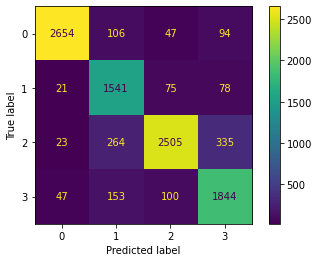

In [210]:
x = confusion_matrix(np.concatenate(correct_all), np.concatenate(preds_all))
ConfusionMatrixDisplay(x).plot()